In [1]:
import random
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# read ERA5 temperature
era5 = xr.open_dataarray("../data/monthly_t2m_europe_19400101-20241231_regrid.nc")

# ERA5 climatology
clim_start = '1993' # '1981-01-01'
clim_end   = '2016' # '2010-12-31'
era5_clim = era5.sel(time=slice(clim_start, clim_end)).groupby('time.month').mean()

anom = era5.groupby('time.month') - era5_clim 

/home/acamilletti/anom_recon/seasonal/.venv/lib/python3.12/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


# Biased vs Bias Corrected
On Copernicus you can find both the bias corrected (2017-last month) and the uncorrected SEAS5 (with hindcast period for verification). I currently don't know which is the ground truth used to bias correct the bias corrected SEAS5 on Copernicus, so it could be incompatible with the ERA5 anomalies. Moreover, I am not 100% sure of which is the climatological period of reference chosed to compute the SEAS5 anomalies.

If I want to solve this issue and have more test dataset, I need to bias correct the uncorrected SEAS5. In this notebook I am going to:
  1. Asses the relevance of the bias correction
  2. Try the quantile delta mapping method to bias correct the uncorrected SEAS5 on the 1993-2016 period, with respect to ERA5 climatology computed in the same period. Then I compare "my" bias corrected SEAS5 with the one available on Copernicus in the 2017-last month range.

In [3]:
# read SEAS5
seas5_biased = xr.open_dataarray("../data/SEAS5_t2m_19810101-20241231_europe_biased.nc").mean(dim='number')
seas5_anom_nobias = xr.open_dataarray("../data/SEAS5_t2m_anom_20170101-20241231_europe_bias_corrected.nc").mean(dim='number')

# SEAS5 prediction time: simply called time for covenience
seas5_anom_nobias = seas5_anom_nobias.rename({'forecast_reference_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})
seas5_biased = seas5_biased.rename({'forecast_reference_time': 'time', 'latitude': 'lat', 'longitude': 'lon'}).sel(time=slice(None, '2024'))

# SEAS5 biased anomalies wrt ERA5 climatology
seas5_anom_biased = xr.DataArray(
    name='t2m',
    dims=['time', 'forecastMonth', 'lat', 'lon'],
    coords=dict(
        time=seas5_biased.time,
        forecastMonth=seas5_biased.forecastMonth,
        lon=seas5_biased.lon,
        lat=seas5_biased.lat
    )
)

for leadtime in range(1,7):
    prediction = seas5_biased.sel(forecastMonth=leadtime)
    valid_times = pd.to_datetime(prediction['time'])
    prediction_times = valid_times + pd.DateOffset(months=leadtime-1)
    prediction['time'] = prediction_times  # shift time for comparison with ground truth
    d = prediction.groupby('time.month')  - era5_clim
    d['time'] = valid_times  # shift back to valid_time
    seas5_anom_biased.loc[dict(forecastMonth=leadtime)] = d

In [4]:
# season prediction (DJF)

# ----------
# ground truth
anom_decs = anom[anom.time.dt.month == 12]  # ground truth for Dec
anom_jans = anom[anom.time.dt.month == 1]   # ground truth for Jan
anom_febs = anom[anom.time.dt.month == 2]   # ground truth for Feb

# ----------
# seas5 error bias corrected
seas5_decs_nobias =  seas5_anom_nobias[seas5_anom_nobias.time.dt.month == 11].sel(forecastMonth=2).drop_vars({'forecastMonth'})  # prediction of Dec from 1st of Dec
seas5_jans_nobias =  seas5_anom_nobias[seas5_anom_nobias.time.dt.month == 11].sel(forecastMonth=3).drop_vars({'forecastMonth'})  # prediction of Jan from 1st of Dec
seas5_febs_nobias =  seas5_anom_nobias[seas5_anom_nobias.time.dt.month == 11].sel(forecastMonth=4).drop_vars({'forecastMonth'})  # prediction of Feb from 1st of Dec

# shift the time to the predicted time
seas5_decs_nobias['time'] = pd.to_datetime(seas5_decs_nobias['time']) + pd.DateOffset(months=1)
seas5_jans_nobias['time'] = pd.to_datetime(seas5_jans_nobias['time']) + pd.DateOffset(months=2)
seas5_febs_nobias['time'] = pd.to_datetime(seas5_febs_nobias['time']) + pd.DateOffset(months=3)

seas5_decs_err_nobias = -(anom_decs - seas5_decs_nobias)
seas5_jans_err_nobias = -(anom_jans  - seas5_jans_nobias)
seas5_febs_err_nobias = -(anom_febs  - seas5_febs_nobias)

# ----------
# seas5 error biased
seas5_decs_biased =  seas5_anom_biased[seas5_anom_biased.time.dt.month == 11].sel(forecastMonth=2).drop_vars({'forecastMonth'})  # prediction of Dec from 1st of Dec
seas5_jans_biased =  seas5_anom_biased[seas5_anom_biased.time.dt.month == 11].sel(forecastMonth=3).drop_vars({'forecastMonth'})  # prediction of Jan from 1st of Dec
seas5_febs_biased =  seas5_anom_biased[seas5_anom_biased.time.dt.month == 11].sel(forecastMonth=4).drop_vars({'forecastMonth'})  # prediction of Feb from 1st of Dec

# shift the time to the predicted time
seas5_decs_biased['time'] = pd.to_datetime(seas5_decs_biased['time']) + pd.DateOffset(months=1)
seas5_jans_biased['time'] = pd.to_datetime(seas5_jans_biased['time']) + pd.DateOffset(months=2)
seas5_febs_biased['time'] = pd.to_datetime(seas5_febs_biased['time']) + pd.DateOffset(months=3)

seas5_decs_err_biased = -(anom_decs - seas5_decs_biased)
seas5_jans_err_biased = -(anom_jans  - seas5_jans_biased)
seas5_febs_err_biased = -(anom_febs  - seas5_febs_biased)

In [5]:
start = pd.to_datetime(seas5_anom_nobias.time.min().data)
end   = pd.to_datetime(seas5_anom_nobias.time.max().data)

Text(0.5, 1.0, 'Bias Corrected Mean Absolute Error')

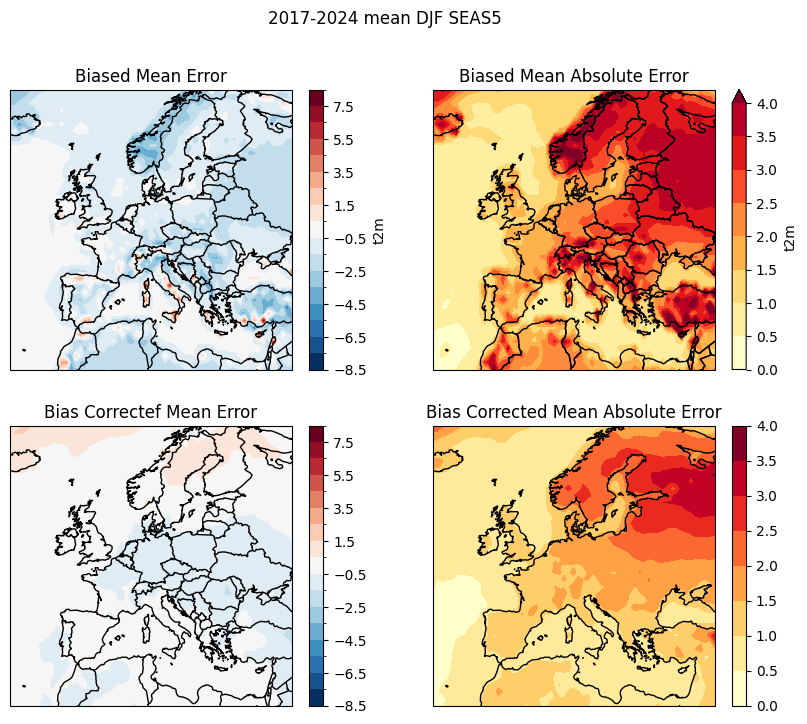

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10,8), subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.suptitle('%s-%s mean DJF SEAS5' % (start.strftime('%Y'), end.strftime('%Y')))

xr.concat([seas5_decs_err_biased, seas5_jans_err_biased, seas5_febs_err_biased], dim='time').mean(dim='time').plot.contourf(ax=axs[0,0], cmap='RdBu_r', vmin=-8.5, vmax=8.5, levels=18)
abs(xr.concat([seas5_decs_err_biased, seas5_jans_err_biased, seas5_febs_err_biased], dim='time')).mean(dim='time').plot.contourf(ax=axs[0,1], cmap='YlOrRd', vmin=0, vmax=4, levels=9)


xr.concat([seas5_decs_err_nobias, seas5_jans_err_nobias, seas5_febs_err_nobias], dim='time').mean(dim='time').plot.contourf(ax=axs[1,0], cmap='RdBu_r', vmin=-8.5, vmax=8.5, levels=18)
abs(xr.concat([seas5_decs_err_nobias, seas5_jans_err_nobias, seas5_febs_err_nobias], dim='time')).mean(dim='time').plot.contourf(ax=axs[1,1], cmap='YlOrRd', vmin=0, vmax=4, levels=9)

axs[0,0].coastlines(), axs[0,1].coastlines()
axs[0,0].add_feature(cfeature.BORDERS), axs[0,1].add_feature(cfeature.BORDERS)
axs[0,0].set_aspect('auto'), axs[0,1].set_aspect('auto')
axs[0,0].set_title('Biased Mean Error')
axs[0,1].set_title('Biased Mean Absolute Error')

axs[1,0].coastlines(), axs[1,1].coastlines()
axs[1,0].add_feature(cfeature.BORDERS), axs[0,1].add_feature(cfeature.BORDERS)
axs[1,0].set_aspect('auto'), axs[1,1].set_aspect('auto')
axs[1,0].set_title('Bias Correctef Mean Error')
axs[1,1].set_title('Bias Corrected Mean Absolute Error')

In [7]:
# seas5 unbiased error (wrt era5 anomalies)
seas5_err_nobias = xr.DataArray(
    dims=['time', 'forecastMonth', 'lat', 'lon'],
    coords=dict(
        time=seas5_anom_nobias.time,
        forecastMonth=seas5_anom_nobias.forecastMonth,
        lon=seas5_anom_nobias.lon,
        lat=seas5_anom_nobias.lat
    )
)

for leadtime in range(1, 7):
    for i in range(leadtime - 1, len(seas5_anom_nobias.time.data)):
        time = seas5_anom_nobias.time.data[i]
        forecast_reference_time = seas5_anom_nobias.time.data[i - leadtime + 1]
        ground_truth = anom.sel(time=time)
        prediction = seas5_anom_nobias.sel(time=forecast_reference_time, forecastMonth=leadtime)
        d = ground_truth - prediction
        seas5_err_nobias.loc[dict(forecastMonth=leadtime, time=forecast_reference_time)] = d   

In [8]:
# seas5 biased error (wrt era5 anomalies)
seas5_err_biased = xr.DataArray(
    dims=['time', 'forecastMonth', 'lat', 'lon'],
    coords=dict(
        time=seas5_anom_biased.time,
        forecastMonth=seas5_anom_biased.forecastMonth,
        lon=seas5_anom_biased.lon,
        lat=seas5_anom_biased.lat
    )
)

for leadtime in range(1, 7):
    for i in range(leadtime - 1, len(seas5_anom_biased.time.data)):
        time = seas5_anom_biased.time.data[i]
        forecast_reference_time = seas5_anom_biased.time.data[i - leadtime + 1]
        ground_truth = anom.sel(time=time)
        prediction = seas5_anom_biased.sel(time=forecast_reference_time, forecastMonth=leadtime)
        d = ground_truth - prediction
        seas5_err_biased.loc[dict(forecastMonth=leadtime, time=forecast_reference_time)] = d   

In [9]:
# 10 y climatology error (wrt era5 anomalies)
anom_clim = xr.DataArray(
    dims=['time', 'lat', 'lon'],
    coords=dict(
        time=anom.time,
        lon=anom.lon,
        lat=anom.lat
    )
)

clim_err = xr.DataArray(
    dims=['time', 'lat', 'lon'],
    coords=dict(
        time=anom.time,
        lon=anom.lon,
        lat=anom.lat
    )
)

for year in range(seas5_anom_nobias.time.dt.year.min().data, seas5_anom_nobias.time.dt.year.max().data + 1):
    anom_clim.loc[dict(time=str(year))] = (era5.sel(time=slice(str(year-11), str(year-1))).groupby('time.month').mean() - era5_clim).data
clim_err = (anom - anom_clim).dropna(dim='time')

Text(0.5, 1.0, 'Bias Corrected')

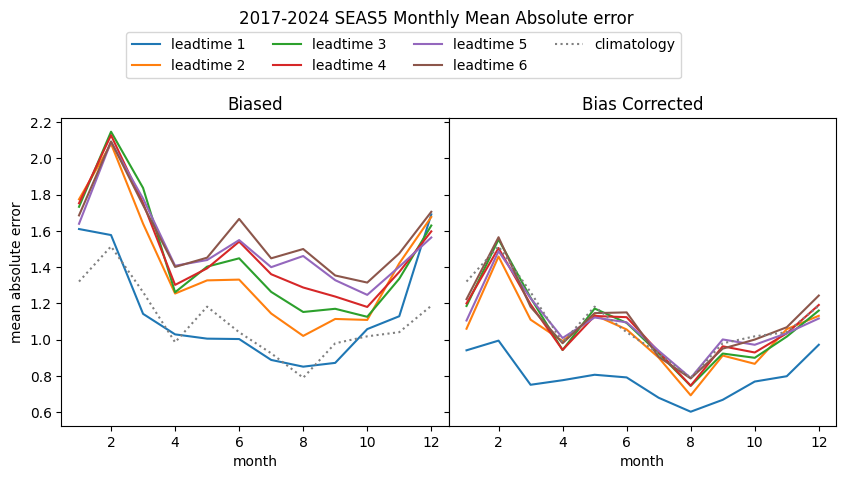

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True, gridspec_kw=dict(wspace=0))
fig.suptitle('%s-%s SEAS5 Monthly Mean Absolute error' % (start.strftime('%Y'), end.strftime('%Y')), y=1.15)

# biased
for leadtime in range(1, 7):
    x = np.arange(leadtime - 1, (12 + leadtime - 1)) % 12 + 1
    s = abs(seas5_err_biased.sel(time=slice(start, end))).groupby('time.month').mean().sel(forecastMonth=leadtime).mean(dim=['lat', 'lon'])
    axs[0].plot(x[x.argsort()], s[x.argsort()], label='leadtime %d' % leadtime)
abs(clim_err.sel(time=slice(start, end))).groupby('time.month').mean().mean(dim=['lat', 'lon']).plot(ax=axs[0], ls=':', color='gray', label='climatology')

# bias corrected
for leadtime in range(1, 7):
    x = np.arange(leadtime - 1, (12 + leadtime - 1)) % 12 + 1
    s = abs(seas5_err_nobias.sel(time=slice(start, end))).groupby('time.month').mean().sel(forecastMonth=leadtime).mean(dim=['lat', 'lon'])
    axs[1].plot(x[x.argsort()], s[x.argsort()], label='leadtime %d' % leadtime)
abs(clim_err.sel(time=slice(start, end))).groupby('time.month').mean().mean(dim=['lat', 'lon']).plot(ax=axs[1], ls=':', color='gray', label='climatology')

axs[0].legend(ncol=4, loc='upper left',  bbox_to_anchor=(.15, 1.3))
axs[0].set_xlabel('month')
axs[0].set_ylabel('mean absolute error')
axs[0].set_title('Biased')
axs[1].set_title('Bias Corrected')

Bias correction is crucial to beat the climatology at forecastMonth < 5!

# Quantile Delta Mapping Bias Correction

In [25]:
from cmethods import adjust

In [26]:
# read ERA5 temperature
era5 = xr.open_dataarray("../data/monthly_t2m_europe_19400101-20241231_regrid.nc")

# ERA5 climatology
clim_start = pd.to_datetime('1993-01-01') # '1981-01-01'
clim_end   = pd.to_datetime('2016-12-31') # '2010-12-31'
era5_clim = era5.sel(time=slice(clim_start, clim_end)).groupby('time.month').mean()

anom = era5.groupby('time.month') - era5_clim 

In [27]:
sim = xr.open_dataarray("../data/SEAS5_t2m_19810101-20241231_europe_biased.nc").sel(number=slice(0,24))  # 25 members are for hindcast
sim = sim.rename({'forecast_reference_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})

In [28]:
sim_anom = xr.DataArray(
    name='t2m',
    dims=['time', 'forecastMonth', 'lat', 'lon', 'number'],
    coords=dict(
        time=sim.time,
        forecastMonth=sim.forecastMonth,
        lon=sim.lon,
        lat=sim.lat,
        number=sim.number
    )
)

for leadtime in range(1,7):
    prediction = sim.sel(forecastMonth=leadtime)
    valid_times = pd.to_datetime(prediction['time'])
    prediction_times = valid_times + pd.DateOffset(months=leadtime-1)
    prediction['time'] = prediction_times  # shift time for comparison with ground truth
    d = prediction.groupby('time.month')  - era5_clim
    d['time'] = valid_times  # shift back to valid_time
    sim_anom.loc[dict(forecastMonth=leadtime)] = d

In [29]:
ref_year_start = '1993'
ref_year_end   = '2016'
leadtime = 2

qdm_result = xr.DataArray(
    dims=['time', 'lon', 'lat', 'number', 'forecastMonth'],
    coords=dict(
        time=anom.sel(time=slice('2017', '2024')).time.data,
        lon=sim.lon,
        lat=sim.lat,
        number=sim.number,
        forecastMonth=sim.forecastMonth
    )
)

In [30]:
sim_anom_slice1  = sim_anom.sel(time=slice('1993', '2016'), forecastMonth=leadtime)
sim_anom_slice2  = sim_anom.sel(time=slice('2017', '2024'), forecastMonth=leadtime)

for number in range(25):
    # biased data
    simh = sim_anom_slice1.sel(number=number)
    simp = sim_anom_slice2.sel(number=number)

    qdm_result.loc[dict(number=number, forecastMonth=leadtime)] = adjust(
        method="quantile_delta_mapping",
        obs=anom.sel(time=slice('1993', '2016')),
        simh=simh,
        simp=simp,
        n_quantiles=1000,
        kind="+",
    ).t2m

In [399]:
# unbiased data
ref = xr.open_dataarray("../data/SEAS5_t2m_anom_20170101-20241231_europe_bias_corrected.nc")
ref = ref.rename({'forecast_reference_time': 'time', 'latitude': 'lat', 'longitude': 'lon'}).sel(time=slice('2017', '2024'), number=slice(0,24))

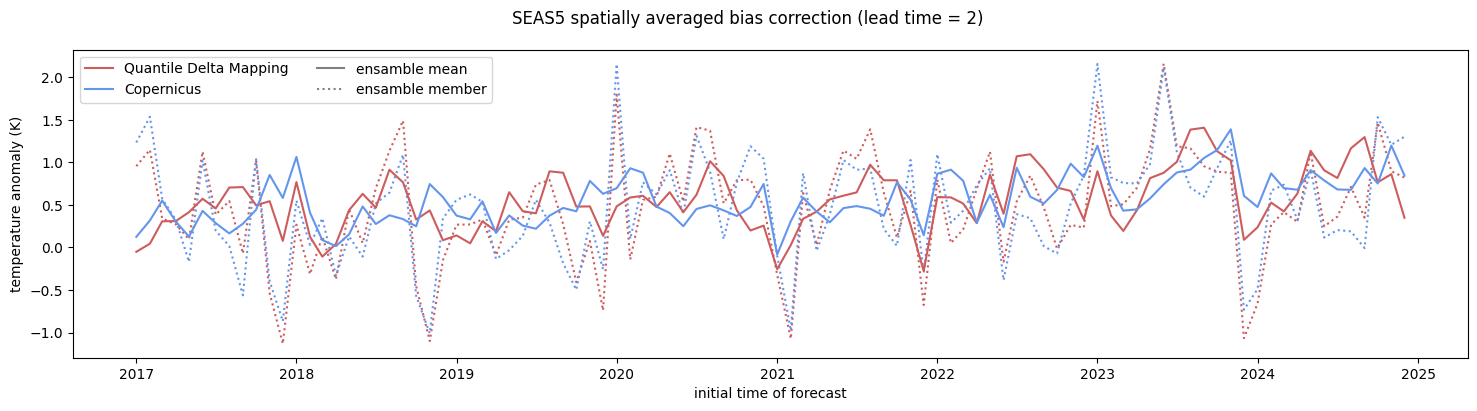

In [418]:
#number = random.randint(0,24)
number = 9

fig = plt.figure(figsize=(18,4))
ax = plt.subplot()
custom_lines = [Line2D([0], [0], color='indianred'), Line2D([0], [0], color='cornflowerblue'), Line2D([0], [0], color='gray'), Line2D([0], [0], ls=':', color='gray')]

qdm_result.sel(number=number, forecastMonth=leadtime).mean(dim=['lon', 'lat']).plot(ax=ax, color='indianred', ls=':',)
ref.sel(number=number, forecastMonth=leadtime).mean(dim=['lon', 'lat']).plot(ax=ax, color='cornflowerblue', ls=':')

qdm_result.sel(forecastMonth=leadtime).mean(dim=['number','lon', 'lat']).plot(ax=ax, color='indianred', label='bias corrected (QDM)')
ref.sel(forecastMonth=leadtime).mean(dim=['number', 'lon', 'lat']).plot(ax=ax, color='cornflowerblue', label='bias corrected (Copernicus)')

fig.suptitle('SEAS5 spatially averaged bias correction (lead time = %d)' % leadtime)
ax.set_title('')
ax.set_ylabel('temperature anomaly (K)')
ax.legend(custom_lines, ['Quantile Delta Mapping', 'Copernicus', 'ensamble mean', 'ensamble member'], ncol=2, loc='upper left')


The error are one magnitude less than the anomalies. Then the quantile delta mapping seems reliable.

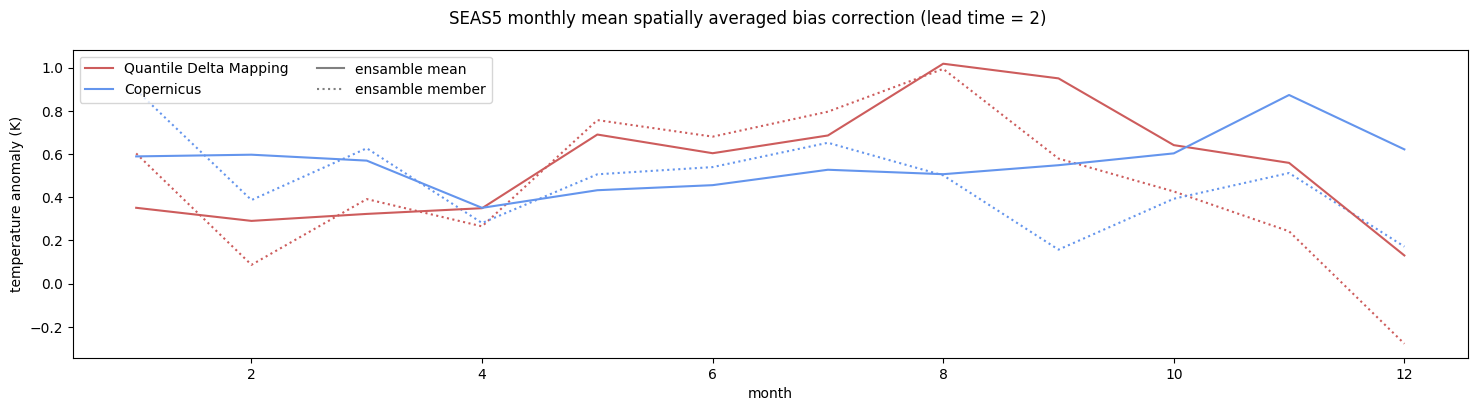

In [419]:
#number = random.randint(0,24)
number = 9

fig = plt.figure(figsize=(18,4))
ax = plt.subplot()
custom_lines = [Line2D([0], [0], color='indianred'), Line2D([0], [0], color='cornflowerblue'), Line2D([0], [0], color='gray'), Line2D([0], [0], ls=':', color='gray')]

qdm_result.sel(number=number, forecastMonth=leadtime).groupby('time.month').mean(...).plot(ax=ax, color='indianred', ls=':',)
ref.sel(number=number, forecastMonth=leadtime).mean(dim=['lon', 'lat']).groupby('time.month').mean(...).plot(ax=ax, color='cornflowerblue', ls=':')

qdm_result.sel(forecastMonth=leadtime).groupby('time.month').mean(...).plot(ax=ax, color='indianred', label='bias corrected (QDM)')
ref.sel(forecastMonth=leadtime).groupby('time.month').mean(...).plot(ax=ax, color='cornflowerblue', label='bias corrected (Copernicus)')

fig.suptitle('SEAS5 monthly mean spatially averaged bias correction (lead time = %d)' % leadtime)
ax.set_title('')
ax.set_ylabel('temperature anomaly (K)')
ax.legend(custom_lines, ['Quantile Delta Mapping', 'Copernicus', 'ensamble mean', 'ensamble member'], ncol=2, loc='upper left')


In [424]:
#qdm_result.sel(forecastMonth=leadtime).mean(dim=['number','lon', 'lat']).plot(ax=ax, color='indianred', label='bias corrected (QDM)')
#ref.sel(forecastMonth=leadtime).mean(dim=['number', 'lon', 'lat']).plot(ax=ax, color='cornflowerblue', label='bias corrected (Copernicus)')

print(abs(qdm_result - ref).mean().data)
print(abs(qdm_result - ref).mean(dim=['lat', 'lon']).max().data)


0.45743248735380615
0.8323537752956778


## Test custom corrected SEAS5 from NetCDF against the Copernicus's corrected SEAS5

Nota that Copernicus's SEAS5 is corrected wrt 1993-2016. Different reference periods/climatology will give different results.

In [436]:
path = '../data/SEAS5_t2m_anom_europe_clim1981-2010_bias1993-2016_20170101-20250101.nc'
custom_seas5 = xr.open_dataarray(path)

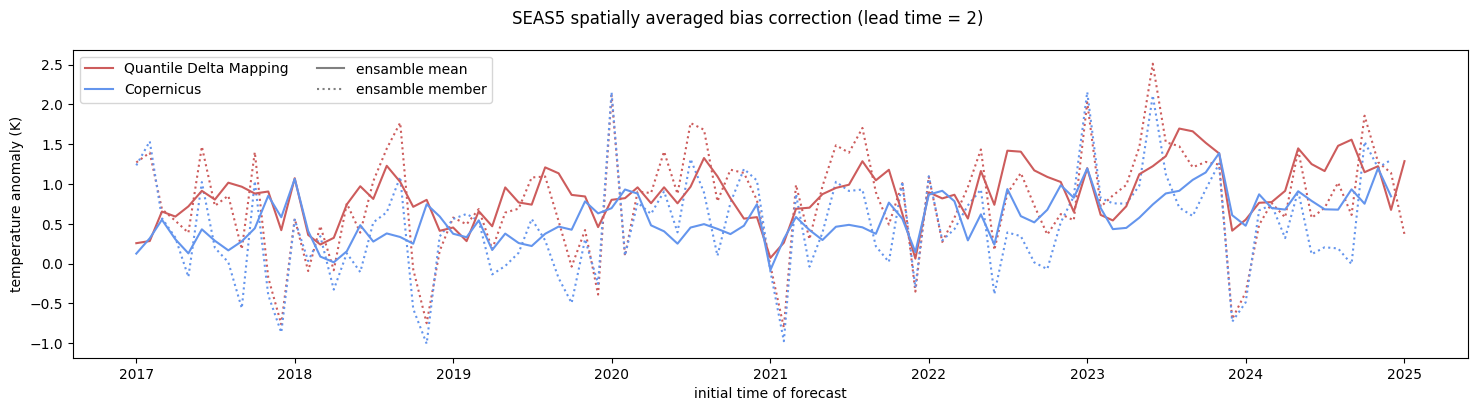

In [438]:
#number = random.randint(0,24)
number = 9
leadtime = 2

fig = plt.figure(figsize=(18,4))
ax = plt.subplot()
custom_lines = [Line2D([0], [0], color='indianred'), Line2D([0], [0], color='cornflowerblue'), Line2D([0], [0], color='gray'), Line2D([0], [0], ls=':', color='gray')]

custom_seas5.sel(number=number, forecastMonth=leadtime).mean(dim=['lon', 'lat']).plot(ax=ax, color='indianred', ls=':',)
ref.sel(number=number, forecastMonth=leadtime).mean(dim=['lon', 'lat']).plot(ax=ax, color='cornflowerblue', ls=':')

custom_seas5.sel(forecastMonth=leadtime).mean(dim=['number','lon', 'lat']).plot(ax=ax, color='indianred', label='bias corrected (QDM)')
ref.sel(forecastMonth=leadtime).mean(dim=['number', 'lon', 'lat']).plot(ax=ax, color='cornflowerblue', label='bias corrected (Copernicus)')

fig.suptitle('SEAS5 spatially averaged bias correction (lead time = %d)' % leadtime)
ax.set_title('')
ax.set_ylabel('temperature anomaly (K)')
ax.legend(custom_lines, ['Quantile Delta Mapping', 'Copernicus', 'ensamble mean', 'ensamble member'], ncol=2, loc='upper left')
